In [227]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [228]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)

In [229]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [230]:
sample = df[df['SpecID'] == "210407-1-01"]

Divided by 400 as that is rougly the range before the peaks were scaled

In [231]:
peak_index, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42/400, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

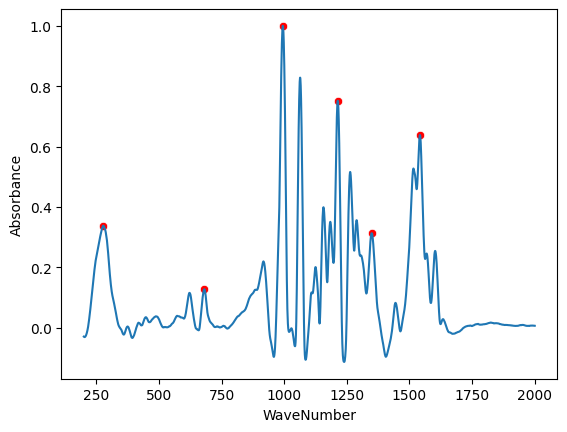

In [232]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peak_index], x="WaveNumber", y="Absorbance", color="red")

In [233]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,0.584637
1,201210-1-00,1,200.68336,201210-1,Normal,0.576621
2,201210-1-00,2,201.36674,201210-1,Normal,0.568924
3,201210-1-00,3,202.05011,201210-1,Normal,0.561545
4,201210-1-00,4,202.73349,201210-1,Normal,0.554483
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,0.093663
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,0.095611
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,0.097670
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,0.099838


In [234]:
peaks = []
widths = []
prominences = []
areas = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/400, width=6)
    # peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

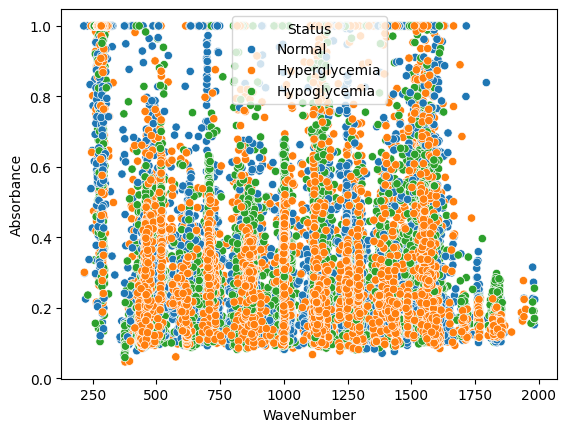

In [235]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue="Status")

In [236]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [237]:
# Set the size of the grid slots
WaveNumber_slot_size = 8
Absorbance_slot_size = 0.01

peaks_df['GridSlot'] = peaks_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

C:\Users\stang\AppData\Local\Temp\ipykernel_4508\1987900641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['GridSlot'] = peaks_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [238]:
peaks_df['GridSlot'].nunique()

5754

In [239]:
peaks_df['Node_ID'] = peaks_df.index

C:\Users\stang\AppData\Local\Temp\ipykernel_4508\3561900980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Node_ID'] = peaks_df.index


In [240]:
peaks_df.drop(columns=['Seq', 'SurID'], inplace=True)

C:\Users\stang\AppData\Local\Temp\ipykernel_4508\4174181308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df.drop(columns=['Seq', 'SurID'], inplace=True)


In [241]:
from itertools import combinations

# Find combinations of SpecID for each GridSlot
grouped = peaks_df.groupby('GridSlot')['SpecID'].apply(list)

# Create new DataFrame for shared peaks
shared_peaks = []

for spec_ids in grouped:
    for combo in combinations(spec_ids, 2):
        shared_peaks.append({'SpecID1:Start_ID': combo[0], 'SpecID2:END_ID': combo[1]})

shared_peaks_df = pd.DataFrame(shared_peaks)

In [242]:
peaks_df['SpecID'].nunique()

3045

In [243]:
shared_peaks_df['SIMILAR:TYPE'] = 'SIMILAR'

In [244]:
# Flatten the SpecID values from both columns of shared_peaks_df into a single set
shared_spec_ids = set(shared_peaks_df['SpecID1:Start_ID'].tolist() + shared_peaks_df['SpecID2:END_ID'].tolist())

# Get the set of SpecID values from peaks_df
original_spec_ids = set(peaks_df['SpecID'].tolist())

# Find the difference between the sets
missing_spec_ids = original_spec_ids - shared_spec_ids

# Count how many values are missing
missing_count = len(missing_spec_ids)

print(f"Number of SpecID values from peaks_df missing in shared_peaks_df: {missing_count}")
if missing_count > 0:
    print("Missing SpecID values:", missing_spec_ids)


Number of SpecID values from peaks_df missing in shared_peaks_df: 0


In [213]:
shared_peaks_df.to_csv('../../data/graph_2_1/relationships.csv')

In [246]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,0.584637
1,201210-1-00,1,200.68336,201210-1,Normal,0.576621
2,201210-1-00,2,201.36674,201210-1,Normal,0.568924
3,201210-1-00,3,202.05011,201210-1,Normal,0.561545
4,201210-1-00,4,202.73349,201210-1,Normal,0.554483
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,0.093663
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,0.095611
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,0.097670
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,0.099838


In [251]:
nodes_df = df.groupby('SpecID')['Absorbance'].agg(list).reset_index()

In [257]:
nodes_df.rename(columns={'Absorbance':'Absorbance:float[]'}, inplace=True)

In [260]:
nodes_df

,SpecID,Absorbance:float[],:LABEL
0,201210-1-00,"[0.5846368667440481, 0.5766214692855114, 0.568...",Spectra
1,201210-1-01,"[0.8522228279874604, 0.8301496801488988, 0.808...",Spectra
2,201210-1-02,"[0.23917417255148796, 0.23086342019424894, 0.2...",Spectra
3,201210-1-03,"[0.26347646565747873, 0.3205993679855202, 0.37...",Spectra
4,201210-1-04,"[0.38813505202040893, 0.38211587024411076, 0.3...",Spectra
...,...,...,...
3040,210526-3-45,"[0.008470611810050628, 0.005020352683992512, 0...",Spectra
3041,210526-3-46,"[0.05497018994538006, 0.04519684799004031, 0.0...",Spectra
3042,210526-3-47,"[0.07315402717028612, 0.06272562101695468, 0.0...",Spectra
3043,210526-3-48,"[0.02686025161046556, 0.0197463518167611, 0.01...",Spectra


In [258]:
nodes_df[':LABEL'] = 'Spectra'

In [259]:
nodes_df.to_csv('../../data/graph_2_1/nodes.csv')

In [224]:
status_df = df.groupby('SpecID')['Status'].first().reset_index()

In [226]:
status_df.to_csv('../../data/graph_2_1/status.csv')